In [ ]:
!pip install transformers

     |████████████████████████████████| 1.4MB 8.6MB/s 
     |████████████████████████████████| 2.9MB 29.0MB/s 
     |████████████████████████████████| 890kB 53.0MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893261 sha256=c91cd39ec917dfa6f9a143e8fb42e66ffb6e8c11cc959c6330342a3db021c666
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
from transformers import *
import json
from tqdm import tqdm
import os

In [ ]:
import os
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [ ]:
os.chdir("/content/gdrive/MyDrive/Colab Notebooks/News_detection/train_test")
os.getcwd()
os.listdir()

['news_semitrain.csv',
 'news_semitest.csv',
 'news_semitest1.csv',
 'news_semitrain1.csv',
 'news_train.csv',
 'test_set.csv',
 'train_set.csv',
 'test set.xlsx']

In [ ]:
train = pd.read_csv("train_set.csv")
test = pd.read_csv("test_set.csv")

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')

In [ ]:
train['Review'] = (train['title'].map(str) +' '+ train['content']).apply(lambda row: row.strip())
test['Review'] = (test['title'].map(str) +' '+ test['content']).apply(lambda row: row.strip())

In [ ]:
train[50:70]

,n_id,date,title,content,ord,information,Review
50,NEWS02810,20200625,공무원·공기업 인건비 160조 육박…공공부문 정규직화의 그늘,"""100만원""만 있어도 지금 당장 ""이것""부터 사라.. .",20,1,"공무원·공기업 인건비 160조 육박…공공부문 정규직화의 그늘 ""100만원""만 있어도..."
51,NEWS02314,20200407,"쿠쿠홀딩스(192400) 소폭 상승세 +4.91%, 나흘째 상승",지주사 테마 개요 및 관련종목 리스트 바로보기,9,1,"쿠쿠홀딩스(192400) 소폭 상승세 +4.91%, 나흘째 상승 지주사 테마 개요..."
52,NEWS08055,20200520,[이학영 칼럼] '윤미향 의혹'보다 걱정스러운 '집단사고',회계투명성 의혹 제기를 놓고 도지사와 장관을 지낸 중진 의원이 친일반(反)인권반(反...,8,0,[이학영 칼럼] '윤미향 의혹'보다 걱정스러운 '집단사고' 회계투명성 의혹 제기를 ...
53,NEWS02780,20200311,"[김영상의 오지랖] “정치풍자, 섹드립 훌훌 다 벗고…” 한때 팬으로서의 자니윤 추모",코미디언 이홍렬은 고인에 대해 스탠드업 코미디로 한국의 위상을 떨치신 분이라고 회고...,47,0,"[김영상의 오지랖] “정치풍자, 섹드립 훌훌 다 벗고…” 한때 팬으로서의 자니윤 추..."
54,NEWS06537,20200317,3∼6월 자동차 구매 시 개소세 70% 인하…신용카드 소득공제 2배로,아울러 감염병 특별재난지역 소재 중소기업들의 경우 올해 한시적으로 소득세와 법인세를...,8,0,3∼6월 자동차 구매 시 개소세 70% 인하…신용카드 소득공제 2배로 아울러 감염병...
55,NEWS01822,20200109,"밖은 -5도, 고수동굴 안은 +15도, 동굴여행 어때요?",충북의 동굴들은 단양에 집중돼 있다,75,0,"밖은 -5도, 고수동굴 안은 +15도, 동굴여행 어때요? 충북의 동굴들은 단양에 집..."
56,NEWS01464,20200521,[분양 포커스]6호선·경의중앙선…‘신내역 시티프라디움’ 관심 집중,"중랑캠핑숲, 봉화산 근린공원, 구릉산 등이 주변에 있다",104,0,"[분양 포커스]6호선·경의중앙선…‘신내역 시티프라디움’ 관심 집중 중랑캠핑숲, 봉화..."
57,NEWS04012,20200326,"평택시, 해외입국자 코로나19 검사 71명 전원 ‘음성’","지난 25일에는 유럽 11명, 미국 5명, 기타 국가 27명 등 총 43명이 선별진...",49,0,"평택시, 해외입국자 코로나19 검사 71명 전원 ‘음성’ 지난 25일에는 유럽 11..."
58,NEWS05112,20200330,위기 도미노…‘제2 두산’ 불안 증폭,CJ CGV는 특히 FI(재무적투자자)들과 함께 8000억원에 인수한 터키 영화관 ...,52,0,위기 도미노…‘제2 두산’ 불안 증폭 CJ CGV는 특히 FI(재무적투자자)들과 함...
59,NEWS03363,20200419,국내 소득 1·2위 직업…기업 고위 임원·국회의원,10%수익을 40%로 만들어 준다고.. 영웅스탁론이라면 가능~.효과적인 레버리지를 ...,37,1,국내 소득 1·2위 직업…기업 고위 임원·국회의원 10%수익을 40%로 만들어 준다...


In [ ]:
def convert_data(data_df):
    global tokenizer
    
    SEQ_LEN = 128 
    
    tokens, masks, segments, targets = [], [], [], []
    
    for i in tqdm(range(len(data_df))):
        token = tokenizer.encode(data_df[DATA_COLUMN][i], max_length=SEQ_LEN, truncation=True, padding='max_length')
       
        num_zeros = token.count(0)
        mask = [1]*(SEQ_LEN-num_zeros) + [0]*num_zeros
        
        segment = [0]*SEQ_LEN

        tokens.append(token)
        masks.append(mask)
        segments.append(segment)
        
        targets.append(data_df[LABEL_COLUMN][i])

    tokens = np.array(tokens)
    masks = np.array(masks)
    segments = np.array(segments)
    targets = np.array(targets)

    return [tokens, masks, segments], targets

def load_data(pandas_dataframe):
    data_df = pandas_dataframe
    data_df[DATA_COLUMN] = data_df[DATA_COLUMN].astype(str)
    data_df[LABEL_COLUMN] = data_df[LABEL_COLUMN].astype(int)
    data_x, data_y = convert_data(data_df)
    return data_x, data_y

SEQ_LEN = 128
BATCH_SIZE = 20
DATA_COLUMN = "Review"
LABEL_COLUMN = "information"

train_x, train_y = load_data(train)

100%|██████████| 94996/94996 [00:50<00:00, 1883.92it/s]


In [ ]:
test_x, test_y = load_data(test)

100%|██████████| 23749/23749 [00:12<00:00, 1892.84it/s]


In [ ]:
model = TFBertModel.from_pretrained('bert-base-multilingual-cased')
token_inputs = tf.keras.layers.Input((SEQ_LEN,), dtype=tf.int32, name='input_word_ids')
mask_inputs = tf.keras.layers.Input((SEQ_LEN,), dtype=tf.int32, name='input_masks')
segment_inputs = tf.keras.layers.Input((SEQ_LEN,), dtype=tf.int32, name='input_segment')
bert_outputs = model([token_inputs, mask_inputs, segment_inputs])

Some layers from the model checkpoint at bert-base-multilingual-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-multilingual-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [ ]:
bert_outputs = bert_outputs[1]
classification_first = tf.keras.layers.Dense(1, activation='sigmoid', kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.02))(bert_outputs)
classification_model = tf.keras.Model([token_inputs, mask_inputs, segment_inputs], classification_first)
classification_model.compile(optimizer=tf.keras.optimizers.Adam(lr=1.0e-5), loss=tf.keras.losses.BinaryCrossentropy(), metrics = [tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.FalsePositives(name='FalsePositive'), 'accuracy'])

In [ ]:
classification_model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 128)]        0                                            
__________________________________________________________________________________________________
input_masks (InputLayer)        [(None, 128)]        0                                            
__________________________________________________________________________________________________
input_segment (InputLayer)      [(None, 128)]        0                                            
__________________________________________________________________________________________________
tf_bert_model (TFBertModel)     TFBaseModelOutputWit 177853440   input_word_ids[0][0]             
                                                                 input_masks[0][0]     

In [ ]:
import tensorflow_addons as tfa
opt = tfa.optimizers.RectifiedAdam(lr=1.0e-5, weight_decay=0.0025)

In [ ]:
def create_classification_bert():
  model = TFBertModel.from_pretrained('bert-base-multilingual-cased')
  token_inputs = tf.keras.layers.Input((SEQ_LEN,), dtype=tf.int32, name='input_word_ids')
  mask_inputs = tf.keras.layers.Input((SEQ_LEN,), dtype=tf.int32, name='input_masks')
  segment_inputs = tf.keras.layers.Input((SEQ_LEN,), dtype=tf.int32, name='input_segment')
  bert_outputs = model([token_inputs, mask_inputs, segment_inputs])

  bert_outputs = bert_outputs[1]
  classification_first = tf.keras.layers.Dense(1, activation='sigmoid', kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.02))(bert_outputs)
  classification_model = tf.keras.Model([token_inputs, mask_inputs, segment_inputs], classification_first)

  classification_model.compile(optimizer=tf.keras.optimizers.Adam(lr=1.0e-5), loss=tf.keras.losses.BinaryCrossentropy(), metrics = [tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.FalsePositives(name='FalsePositive'), 'accuracy'])
  return classification_model

In [ ]:
classification_model = create_classification_bert()
  
hist = classification_model.fit(train_x, train_y, epochs=4, shuffle=True, batch_size=20, validation_data=(test_x, test_y))

Some layers from the model checkpoint at bert-base-multilingual-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-multilingual-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Epoch 1/4
4750/4750 [==============================] - 1774s 374ms/step - loss: 0.0506 - precision: 0.9742 - FalsePositive: 974.0000 - accuracy: 0.9812 - val_loss: 0.0270 - val_precision: 0.9899 - val_FalsePositive: 95.0000 - val_accuracy: 0.9909
Epoch 2/4
4750/4750 [==============================] - 1769s 372ms/step - loss: 0.0186 - precision: 0.9913 - FalsePositive: 325.0000 - accuracy: 0.9934 - val_loss: 0.0236 - val_precision: 0.9937 - val_FalsePositive: 59.0000 - val_accuracy: 0.9922
Epoch 3/4
4750/4750 [==============================] - 1769s 372ms/step - loss: 0.0110 - precision: 0.9953 - FalsePositive: 175.0000 - accuracy: 0.9965 - val_loss: 0.0217 - val_precision: 0.9948 - val_FalsePositive: 49.0000 - val_accuracy: 0.9939
Epoch 4/4
4750/4750 [==============================] - 1769s 372ms/step - loss: 0.0069 - precision: 0.9975 - FalsePositive: 93.0000 - accuracy: 0.9978 - val_loss: 0.0234 - val_precision: 0.9935 - val_FalsePositive: 61.0000 - val_accuracy: 0.9941


In [ ]:
print(hist.history['loss'])
print(hist.history['accuracy']) 
print(hist.history['precision'])

[0.05056866258382797, 0.018644265830516815, 0.010996229015290737, 0.006860386114567518]
[0.9812307953834534, 0.9934207797050476, 0.9964525103569031, 0.9977893829345703]
[0.9741719961166382, 0.9913496971130371, 0.9953406453132629, 0.9975214600563049]


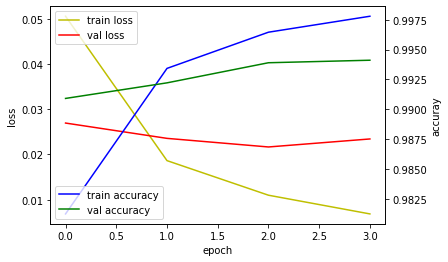

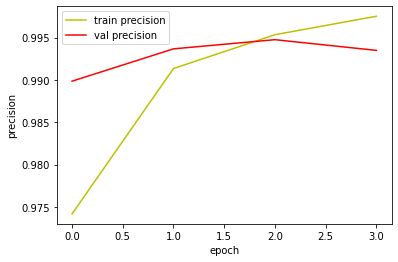

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')

acc_ax.plot(hist.history['accuracy'], 'b', label='train accuracy')
acc_ax.plot(hist.history['val_accuracy'], 'g', label='val accuracy')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuray')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

####################################
fig, prec_ax = plt.subplots()

prec_ax.plot(hist.history['precision'], 'y', label='train precision')
prec_ax.plot(hist.history['val_precision'], 'r', label='val precision')

prec_ax.set_xlabel('epoch')
prec_ax.set_ylabel('precision')

prec_ax.legend(loc='upper left')

plt.show()

In [ ]:
path = "/content/gdrive/My Drive/Colab Notebooks/News_detection"

In [ ]:
os.getcwd()

'/content/gdrive/My Drive/Colab Notebooks/News_detection/train_test'

In [ ]:
classification_model.save_weights(path+"/News_detection_ver3(noprepro_multibert_title).h5")

In [ ]:
def sentence_convert_data(data):
    global tokenizer
    tokens, masks, segments = [], [], []
    token = tokenizer.encode(data, max_length=SEQ_LEN, truncation=True, padding='max_length')
    
    num_zeros = token.count(0) 
    mask = [1]*(SEQ_LEN-num_zeros) + [0]*num_zeros 
    segment = [0]*SEQ_LEN

    tokens.append(token)
    segments.append(segment)
    masks.append(mask)

    tokens = np.array(tokens)
    masks = np.array(masks)
    segments = np.array(segments)
    return [tokens, masks, segments]

def information_evaluation_predict(sentence):
    data_x = sentence_convert_data(sentence)
    predict = classification_model.predict(data_x)
    predict_value = np.ravel(predict)
    predict_answer = np.round(predict_value,0).item()
    
    if predict_answer == 0:
      print("(정보가 있을 확률 : %.2f) 정보가 있는 문장입니다." % (1-predict_value))
    elif predict_answer == 1:
      print("(정보가 없을 확률 : %.2f) 정보가 없는 문장입니다." % predict_value)